In [1]:
import numpy as np
import pandas as pd
import torch
from config import load_config
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger
from tqdm import tqdm
from tsnecuda import TSNE
from matplotlib import pyplot as plt
import seaborn as sns
import faiss

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

/tmp/ipykernel_2549480/3445827236.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
# parameters
dataset_name = ""
model_name = "resnet_ce_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "CIFAR10"
ood = ""


In [4]:
# initialize data attributes and loaders
config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

Files already downloaded and verified


  0%|                                                                                                                             | 0/50000 [00:00<?, ?it/s]

  9%|█████████▋                                                                                                     | 4371/50000 [00:00<00:01, 43700.77it/s]

 17%|███████████████████▍                                                                                           | 8742/50000 [00:00<00:00, 43272.82it/s]

 26%|████████████████████████████▉                                                                                 | 13171/50000 [00:00<00:00, 43734.15it/s]

 35%|██████████████████████████████████████▋                                                                       | 17612/50000 [00:00<00:00, 43997.21it/s]

 44%|████████████████████████████████████████████████▍                                                             | 22013/50000 [00:00<00:00, 43594.25it/s]

 53%|██████████████████████████████████████████████████████████▏                                                   | 26450/50000 [00:00<00:00, 43852.57it/s]

 62%|███████████████████████████████████████████████████████████████████▊                                          | 30836/50000 [00:00<00:00, 43836.92it/s]

 70%|█████████████████████████████████████████████████████████████████████████████▍                                | 35221/50000 [00:00<00:00, 43820.70it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████▎                      | 39661/50000 [00:00<00:00, 43999.35it/s]

 88%|████████████████████████████████████████████████████████████████████████████████████████████████▉             | 44077/50000 [00:01<00:00, 44047.82it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 48516/50000 [00:01<00:00, 44151.67it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [00:01<00:00, 43919.32it/s]

Files already downloaded and verified


  0%|                                                                                                                             | 0/10000 [00:00<?, ?it/s]

 40%|████████████████████████████████████████████▊                                                                  | 4041/10000 [00:00<00:00, 40404.93it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████▋                     | 8082/10000 [00:00<00:00, 40227.91it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:00<00:00, 40903.00it/s]

In [5]:
# initialize data modules
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

In [6]:
# model ids
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

 ks6467y3


In [7]:
# load model and weights
model = config.get_model()
artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb: Downloading large artifact model-ks6467y3:best, 58.56MB. 1 files... 


wandb:   1 of 1 files downloaded.  


Done. 0:0:0.3


In [8]:
# create data loaders
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [9]:
# forward pass
with torch.no_grad():
    trn_inp = []
    trn_rcn = []
    trn_emb = []
    trn_lgt = []
    trn_tgt = []
    trn_rcn_fpi = []
    trn_emb_fpi = []
    trn_lgt_fpi = []

    val_inp = []
    val_rcn = []
    val_emb = []
    val_lgt = []
    val_tgt = []
    val_rcn_fpi = []
    val_emb_fpi = []
    val_lgt_fpi = []

    ind_inp = []
    ind_rcn = []
    ind_emb = []
    ind_lgt = []
    ind_tgt = []
    ind_rcn_fpi = []
    ind_emb_fpi = []
    ind_lgt_fpi = []

    if ood_str:
        ood_inp = []
        ood_rcn = []
        ood_emb = []
        ood_lgt = []
        ood_tgt = []
        ood_rcn_fpi = []
        ood_emb_fpi = []
        ood_lgt_fpi = []

    rnd_inp = []
    rnd_rcn = []
    rnd_emb = []
    rnd_lgt = []
    rnd_rcn_fpi = []
    rnd_emb_fpi = []
    rnd_lgt_fpi = []

    fpi = 10

    # train set (ind)
    for batch_idx, batch in enumerate(tqdm(train_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        trn_inp.extend(x.detach().cpu().numpy())
        trn_rcn.extend(rcn.detach().cpu().numpy())
        trn_emb.extend(emb.detach().cpu().numpy())
        trn_lgt.extend(lgt.detach().cpu().numpy())
        trn_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        trn_rcn_fpi.extend(rcn.detach().cpu().numpy())
        trn_emb_fpi.extend(emb.detach().cpu().numpy())
        trn_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("train - OK")

    # val set (ind)
    for batch_idx, batch in enumerate(tqdm(val_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        val_inp.extend(x.detach().cpu().numpy())
        val_rcn.extend(rcn.detach().cpu().numpy())
        val_emb.extend(emb.detach().cpu().numpy())
        val_lgt.extend(lgt.detach().cpu().numpy())
        val_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        val_rcn_fpi.extend(rcn.detach().cpu().numpy())
        val_emb_fpi.extend(emb.detach().cpu().numpy())
        val_lgt_fpi.extend(lgt.detach().cpu().numpy())
        
    print("val - OK")

    # test set (ind)
    for batch_idx, batch in enumerate(tqdm(test_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        ind_inp.extend(x.detach().cpu().numpy())
        ind_rcn.extend(rcn.detach().cpu().numpy())
        ind_emb.extend(emb.detach().cpu().numpy())
        ind_lgt.extend(lgt.detach().cpu().numpy())
        ind_tgt.extend(y.detach().cpu().numpy())
        for _ in range(fpi):
            emb, lgt, rcn = model(rcn)
        ind_rcn_fpi.extend(rcn.detach().cpu().numpy())
        ind_emb_fpi.extend(emb.detach().cpu().numpy())
        ind_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test InD - OK")

    # predict set (ood)
    if ood_str:
        for batch_idx, batch in enumerate(tqdm(predict_loader)):
            x, y, *_ = batch
            x = x.float().cuda()
            emb, lgt, rcn = model(x)
            ood_inp.extend(x.detach().cpu().numpy())
            ood_rcn.extend(rcn.detach().cpu().numpy())
            ood_emb.extend(emb.detach().cpu().numpy())
            ood_lgt.extend(lgt.detach().cpu().numpy())
            ood_tgt.extend(y.detach().cpu().numpy())
            for _ in range(fpi):
                emb, lgt, rcn = model(rcn)
            ood_rcn_fpi.extend(rcn.detach().cpu().numpy())
            ood_emb_fpi.extend(emb.detach().cpu().numpy())
            ood_lgt_fpi.extend(lgt.detach().cpu().numpy())
        print("test OoD - OK")

    # random set
    rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
    for batch_idx, batch in enumerate(tqdm(rnd_set)):
        x = batch
        x = x.float().cuda()
        emb, lgt, rcn = model(x)
        rnd_inp.extend(x.detach().cpu().numpy())
        rnd_rcn.extend(rcn.detach().cpu().numpy())
        rnd_emb.extend(emb.detach().cpu().numpy())
        rnd_lgt.extend(lgt.detach().cpu().numpy())
        for i in range(fpi):
            emb, lgt, rcn = model(rcn)
        rnd_rcn_fpi.extend(rcn.detach().cpu().numpy())
        rnd_emb_fpi.extend(emb.detach().cpu().numpy())
        rnd_lgt_fpi.extend(lgt.detach().cpu().numpy())
    print("test RnD - OK")

  0%|                                                                                                                               | 0/313 [00:00<?, ?it/s]

  0%|▍                                                                                                                      | 1/313 [00:00<02:53,  1.80it/s]

  1%|█▏                                                                                                                     | 3/313 [00:00<00:59,  5.20it/s]

  2%|█▉                                                                                                                     | 5/313 [00:00<00:38,  7.91it/s]

  2%|██▋                                                                                                                    | 7/313 [00:00<00:30, 10.00it/s]

  3%|███▍                                                                                                                   | 9/313 [00:01<00:26, 11.56it/s]

  4%|████▏                                                                                                                 | 11/313 [00:01<00:23, 12.70it/s]

  4%|████▉                                                                                                                 | 13/313 [00:01<00:22, 13.53it/s]

  5%|█████▋                                                                                                                | 15/313 [00:01<00:21, 14.12it/s]

  5%|██████▍                                                                                                               | 17/313 [00:01<00:20, 14.55it/s]

  6%|███████▏                                                                                                              | 19/313 [00:01<00:19, 14.85it/s]

  7%|███████▉                                                                                                              | 21/313 [00:01<00:19, 15.07it/s]

  7%|████████▋                                                                                                             | 23/313 [00:01<00:19, 15.22it/s]

  8%|█████████▍                                                                                                            | 25/313 [00:02<00:18, 15.32it/s]

  9%|██████████▏                                                                                                           | 27/313 [00:02<00:18, 15.40it/s]

  9%|██████████▉                                                                                                           | 29/313 [00:02<00:18, 15.44it/s]

 10%|███████████▋                                                                                                          | 31/313 [00:02<00:18, 15.48it/s]

 11%|████████████▍                                                                                                         | 33/313 [00:02<00:18, 15.50it/s]

 11%|█████████████▏                                                                                                        | 35/313 [00:02<00:17, 15.52it/s]

 12%|█████████████▉                                                                                                        | 37/313 [00:02<00:17, 15.53it/s]

 12%|██████████████▋                                                                                                       | 39/313 [00:02<00:17, 15.53it/s]

 13%|███████████████▍                                                                                                      | 41/313 [00:03<00:17, 15.54it/s]

 14%|████████████████▏                                                                                                     | 43/313 [00:03<00:17, 15.55it/s]

 14%|████████████████▉                                                                                                     | 45/313 [00:03<00:17, 15.56it/s]

 15%|█████████████████▋                                                                                                    | 47/313 [00:03<00:17, 15.56it/s]

 16%|██████████████████▍                                                                                                   | 49/313 [00:03<00:16, 15.55it/s]

 16%|███████████████████▏                                                                                                  | 51/313 [00:03<00:16, 15.56it/s]

 17%|███████████████████▉                                                                                                  | 53/313 [00:03<00:16, 15.56it/s]

 18%|████████████████████▋                                                                                                 | 55/313 [00:04<00:16, 15.57it/s]

 18%|█████████████████████▍                                                                                                | 57/313 [00:04<00:16, 15.57it/s]

 19%|██████████████████████▏                                                                                               | 59/313 [00:04<00:16, 15.56it/s]

 19%|██████████████████████▉                                                                                               | 61/313 [00:04<00:16, 15.56it/s]

 20%|███████████████████████▊                                                                                              | 63/313 [00:04<00:16, 15.56it/s]

 21%|████████████████████████▌                                                                                             | 65/313 [00:04<00:15, 15.56it/s]

 21%|█████████████████████████▎                                                                                            | 67/313 [00:04<00:15, 15.56it/s]

 22%|██████████████████████████                                                                                            | 69/313 [00:04<00:15, 15.57it/s]

 23%|██████████████████████████▊                                                                                           | 71/313 [00:05<00:15, 15.56it/s]

 23%|███████████████████████████▌                                                                                          | 73/313 [00:05<00:15, 15.56it/s]

 24%|████████████████████████████▎                                                                                         | 75/313 [00:05<00:15, 15.57it/s]

 25%|█████████████████████████████                                                                                         | 77/313 [00:05<00:15, 15.56it/s]

 25%|█████████████████████████████▊                                                                                        | 79/313 [00:05<00:15, 15.56it/s]

 26%|██████████████████████████████▌                                                                                       | 81/313 [00:05<00:14, 15.57it/s]

 27%|███████████████████████████████▎                                                                                      | 83/313 [00:05<00:14, 15.55it/s]

 27%|████████████████████████████████                                                                                      | 85/313 [00:05<00:14, 15.56it/s]

 28%|████████████████████████████████▊                                                                                     | 87/313 [00:06<00:14, 15.56it/s]

 28%|█████████████████████████████████▌                                                                                    | 89/313 [00:06<00:14, 15.57it/s]

 29%|██████████████████████████████████▎                                                                                   | 91/313 [00:06<00:14, 15.57it/s]

 30%|███████████████████████████████████                                                                                   | 93/313 [00:06<00:14, 15.57it/s]

 30%|███████████████████████████████████▊                                                                                  | 95/313 [00:06<00:14, 15.56it/s]

 31%|████████████████████████████████████▌                                                                                 | 97/313 [00:06<00:13, 15.56it/s]

 32%|█████████████████████████████████████▎                                                                                | 99/313 [00:06<00:13, 15.56it/s]

 32%|█████████████████████████████████████▊                                                                               | 101/313 [00:06<00:13, 15.57it/s]

 33%|██████████████████████████████████████▌                                                                              | 103/313 [00:07<00:13, 15.57it/s]

 34%|███████████████████████████████████████▏                                                                             | 105/313 [00:07<00:13, 15.57it/s]

 34%|███████████████████████████████████████▉                                                                             | 107/313 [00:07<00:13, 15.56it/s]

 35%|████████████████████████████████████████▋                                                                            | 109/313 [00:07<00:13, 15.56it/s]

 35%|█████████████████████████████████████████▍                                                                           | 111/313 [00:07<00:12, 15.57it/s]

 36%|██████████████████████████████████████████▏                                                                          | 113/313 [00:07<00:12, 15.57it/s]

 37%|██████████████████████████████████████████▉                                                                          | 115/313 [00:07<00:12, 15.57it/s]

 37%|███████████████████████████████████████████▋                                                                         | 117/313 [00:08<00:12, 15.57it/s]

 38%|████████████████████████████████████████████▍                                                                        | 119/313 [00:08<00:12, 15.57it/s]

 39%|█████████████████████████████████████████████▏                                                                       | 121/313 [00:08<00:12, 15.56it/s]

 39%|█████████████████████████████████████████████▉                                                                       | 123/313 [00:08<00:12, 15.56it/s]

 40%|██████████████████████████████████████████████▋                                                                      | 125/313 [00:08<00:12, 15.56it/s]

 41%|███████████████████████████████████████████████▍                                                                     | 127/313 [00:08<00:11, 15.56it/s]

 41%|████████████████████████████████████████████████▏                                                                    | 129/313 [00:08<00:11, 15.56it/s]

 42%|████████████████████████████████████████████████▉                                                                    | 131/313 [00:08<00:11, 15.56it/s]

 42%|█████████████████████████████████████████████████▋                                                                   | 133/313 [00:09<00:11, 15.57it/s]

 43%|██████████████████████████████████████████████████▍                                                                  | 135/313 [00:09<00:11, 15.57it/s]

 44%|███████████████████████████████████████████████████▏                                                                 | 137/313 [00:09<00:11, 15.55it/s]

 44%|███████████████████████████████████████████████████▉                                                                 | 139/313 [00:09<00:11, 15.56it/s]

 45%|████████████████████████████████████████████████████▋                                                                | 141/313 [00:09<00:11, 15.56it/s]

 46%|█████████████████████████████████████████████████████▍                                                               | 143/313 [00:09<00:10, 15.57it/s]

 46%|██████████████████████████████████████████████████████▏                                                              | 145/313 [00:09<00:10, 15.58it/s]

 47%|██████████████████████████████████████████████████████▉                                                              | 147/313 [00:09<00:10, 15.58it/s]

 48%|███████████████████████████████████████████████████████▋                                                             | 149/313 [00:10<00:10, 15.58it/s]

 48%|████████████████████████████████████████████████████████▍                                                            | 151/313 [00:10<00:10, 15.58it/s]

 49%|█████████████████████████████████████████████████████████▏                                                           | 153/313 [00:10<00:10, 15.58it/s]

 50%|█████████████████████████████████████████████████████████▉                                                           | 155/313 [00:10<00:10, 15.56it/s]

 50%|██████████████████████████████████████████████████████████▋                                                          | 157/313 [00:10<00:10, 15.56it/s]

 51%|███████████████████████████████████████████████████████████▍                                                         | 159/313 [00:10<00:09, 15.57it/s]

 51%|████████████████████████████████████████████████████████████▏                                                        | 161/313 [00:10<00:09, 15.57it/s]

 52%|████████████████████████████████████████████████████████████▉                                                        | 163/313 [00:10<00:09, 15.57it/s]

 53%|█████████████████████████████████████████████████████████████▋                                                       | 165/313 [00:11<00:09, 15.57it/s]

 53%|██████████████████████████████████████████████████████████████▍                                                      | 167/313 [00:11<00:09, 15.57it/s]

 54%|███████████████████████████████████████████████████████████████▏                                                     | 169/313 [00:11<00:09, 15.57it/s]

 55%|███████████████████████████████████████████████████████████████▉                                                     | 171/313 [00:11<00:09, 15.57it/s]

 55%|████████████████████████████████████████████████████████████████▋                                                    | 173/313 [00:11<00:08, 15.57it/s]

 56%|█████████████████████████████████████████████████████████████████▍                                                   | 175/313 [00:11<00:08, 15.56it/s]

 57%|██████████████████████████████████████████████████████████████████▏                                                  | 177/313 [00:11<00:08, 15.57it/s]

 57%|██████████████████████████████████████████████████████████████████▉                                                  | 179/313 [00:11<00:08, 15.57it/s]

 58%|███████████████████████████████████████████████████████████████████▋                                                 | 181/313 [00:12<00:08, 15.57it/s]

 58%|████████████████████████████████████████████████████████████████████▍                                                | 183/313 [00:12<00:08, 15.57it/s]

 59%|█████████████████████████████████████████████████████████████████████▏                                               | 185/313 [00:12<00:08, 15.57it/s]

 60%|█████████████████████████████████████████████████████████████████████▉                                               | 187/313 [00:12<00:08, 15.57it/s]

 60%|██████████████████████████████████████████████████████████████████████▋                                              | 189/313 [00:12<00:07, 15.57it/s]

 61%|███████████████████████████████████████████████████████████████████████▍                                             | 191/313 [00:12<00:07, 15.57it/s]

 62%|████████████████████████████████████████████████████████████████████████▏                                            | 193/313 [00:12<00:07, 15.58it/s]

 62%|████████████████████████████████████████████████████████████████████████▉                                            | 195/313 [00:13<00:07, 15.57it/s]

 63%|█████████████████████████████████████████████████████████████████████████▋                                           | 197/313 [00:13<00:07, 15.54it/s]

 64%|██████████████████████████████████████████████████████████████████████████▍                                          | 199/313 [00:13<00:07, 15.55it/s]

 64%|███████████████████████████████████████████████████████████████████████████▏                                         | 201/313 [00:13<00:07, 15.56it/s]

 65%|███████████████████████████████████████████████████████████████████████████▉                                         | 203/313 [00:13<00:07, 15.56it/s]

 65%|████████████████████████████████████████████████████████████████████████████▋                                        | 205/313 [00:13<00:06, 15.57it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▍                                       | 207/313 [00:13<00:06, 15.57it/s]

 67%|██████████████████████████████████████████████████████████████████████████████                                       | 209/313 [00:13<00:06, 15.57it/s]

 67%|██████████████████████████████████████████████████████████████████████████████▊                                      | 211/313 [00:14<00:06, 15.57it/s]

 68%|███████████████████████████████████████████████████████████████████████████████▌                                     | 213/313 [00:14<00:06, 15.57it/s]

 69%|████████████████████████████████████████████████████████████████████████████████▎                                    | 215/313 [00:14<00:06, 15.57it/s]

 69%|█████████████████████████████████████████████████████████████████████████████████                                    | 217/313 [00:14<00:06, 15.57it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████▊                                   | 219/313 [00:14<00:06, 15.57it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████▌                                  | 221/313 [00:14<00:05, 15.54it/s]

 71%|███████████████████████████████████████████████████████████████████████████████████▎                                 | 223/313 [00:14<00:05, 15.55it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████                                 | 225/313 [00:14<00:05, 15.56it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████▊                                | 227/313 [00:15<00:05, 15.56it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████▌                               | 229/313 [00:15<00:05, 15.57it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████▎                              | 231/313 [00:15<00:05, 15.57it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████                              | 233/313 [00:15<00:05, 15.57it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████▊                             | 235/313 [00:15<00:05, 15.57it/s]

 76%|████████████████████████████████████████████████████████████████████████████████████████▌                            | 237/313 [00:15<00:04, 15.57it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▎                           | 239/313 [00:15<00:04, 15.57it/s]

 77%|██████████████████████████████████████████████████████████████████████████████████████████                           | 241/313 [00:15<00:04, 15.57it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████▊                          | 243/313 [00:16<00:04, 15.57it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████▌                         | 245/313 [00:16<00:04, 15.57it/s]

 79%|████████████████████████████████████████████████████████████████████████████████████████████▎                        | 247/313 [00:16<00:04, 15.56it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████                        | 249/313 [00:16<00:04, 15.53it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████▊                       | 251/313 [00:16<00:03, 15.55it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████▌                      | 253/313 [00:16<00:03, 15.56it/s]

 81%|███████████████████████████████████████████████████████████████████████████████████████████████▎                     | 255/313 [00:16<00:03, 15.56it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████                     | 257/313 [00:17<00:03, 15.57it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 259/313 [00:17<00:03, 15.57it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 261/313 [00:17<00:03, 15.57it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 263/313 [00:17<00:03, 15.57it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████                  | 265/313 [00:17<00:03, 15.57it/s]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 267/313 [00:17<00:02, 15.57it/s]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 269/313 [00:17<00:02, 15.57it/s]

 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 271/313 [00:17<00:02, 15.57it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████               | 273/313 [00:18<00:02, 15.57it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 275/313 [00:18<00:02, 15.57it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 277/313 [00:18<00:02, 15.58it/s]

 89%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 279/313 [00:18<00:02, 15.58it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████            | 281/313 [00:18<00:02, 15.55it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 283/313 [00:18<00:01, 15.57it/s]

 91%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 285/313 [00:18<00:01, 15.58it/s]

 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 287/313 [00:18<00:01, 15.57it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 289/313 [00:19<00:01, 15.58it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 291/313 [00:19<00:01, 15.57it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 293/313 [00:19<00:01, 15.57it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 295/313 [00:19<00:01, 15.57it/s]

 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 297/313 [00:19<00:01, 15.57it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 299/313 [00:19<00:00, 15.57it/s]

 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 301/313 [00:19<00:00, 15.57it/s]

 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 303/313 [00:19<00:00, 15.56it/s]

 97%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 305/313 [00:20<00:00, 15.51it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 307/313 [00:20<00:00, 15.53it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 309/313 [00:20<00:00, 15.54it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 311/313 [00:20<00:00, 15.55it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.27it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 313/313 [00:20<00:00, 15.17it/s]

train - OK


  0%|                                                                                                                                | 0/79 [00:00<?, ?it/s]

  1%|█▌                                                                                                                      | 1/79 [00:00<00:12,  6.41it/s]

  4%|████▌                                                                                                                   | 3/79 [00:00<00:06, 11.31it/s]

  6%|███████▌                                                                                                                | 5/79 [00:00<00:05, 13.15it/s]

  9%|██████████▋                                                                                                             | 7/79 [00:00<00:05, 14.07it/s]

 11%|█████████████▋                                                                                                          | 9/79 [00:00<00:04, 14.59it/s]

 14%|████████████████▌                                                                                                      | 11/79 [00:00<00:04, 14.91it/s]

 16%|███████████████████▌                                                                                                   | 13/79 [00:00<00:04, 15.12it/s]

 19%|██████████████████████▌                                                                                                | 15/79 [00:01<00:04, 15.26it/s]

 22%|█████████████████████████▌                                                                                             | 17/79 [00:01<00:04, 15.35it/s]

 24%|████████████████████████████▌                                                                                          | 19/79 [00:01<00:03, 15.42it/s]

 27%|███████████████████████████████▋                                                                                       | 21/79 [00:01<00:03, 15.46it/s]

 29%|██████████████████████████████████▋                                                                                    | 23/79 [00:01<00:03, 15.49it/s]

 32%|█████████████████████████████████████▋                                                                                 | 25/79 [00:01<00:03, 15.51it/s]

 34%|████████████████████████████████████████▋                                                                              | 27/79 [00:01<00:03, 15.53it/s]

 37%|███████████████████████████████████████████▋                                                                           | 29/79 [00:01<00:03, 15.54it/s]

 39%|██████████████████████████████████████████████▋                                                                        | 31/79 [00:02<00:03, 15.55it/s]

 42%|█████████████████████████████████████████████████▋                                                                     | 33/79 [00:02<00:02, 15.55it/s]

 44%|████████████████████████████████████████████████████▋                                                                  | 35/79 [00:02<00:02, 15.56it/s]

 47%|███████████████████████████████████████████████████████▋                                                               | 37/79 [00:02<00:02, 15.56it/s]

 49%|██████████████████████████████████████████████████████████▋                                                            | 39/79 [00:02<00:02, 15.56it/s]

 52%|█████████████████████████████████████████████████████████████▊                                                         | 41/79 [00:02<00:02, 15.56it/s]

 54%|████████████████████████████████████████████████████████████████▊                                                      | 43/79 [00:02<00:02, 15.56it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                   | 45/79 [00:02<00:02, 15.57it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                | 47/79 [00:03<00:02, 15.57it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                             | 49/79 [00:03<00:01, 15.56it/s]

 65%|████████████████████████████████████████████████████████████████████████████▊                                          | 51/79 [00:03<00:01, 15.56it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▊                                       | 53/79 [00:03<00:01, 15.56it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▊                                    | 55/79 [00:03<00:01, 15.57it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▊                                 | 57/79 [00:03<00:01, 15.56it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▊                              | 59/79 [00:03<00:01, 15.56it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                           | 61/79 [00:04<00:01, 15.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▉                        | 63/79 [00:04<00:01, 15.57it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 65/79 [00:04<00:00, 15.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 67/79 [00:04<00:00, 15.56it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 69/79 [00:04<00:00, 15.57it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 71/79 [00:04<00:00, 15.57it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 73/79 [00:04<00:00, 15.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 75/79 [00:04<00:00, 15.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77/79 [00:05<00:00, 15.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.60it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.18it/s]

val - OK


  0%|                                                                                                                                | 0/79 [00:00<?, ?it/s]

  1%|█▌                                                                                                                      | 1/79 [00:00<00:12,  6.04it/s]

  4%|████▌                                                                                                                   | 3/79 [00:00<00:06, 11.01it/s]

  6%|███████▌                                                                                                                | 5/79 [00:00<00:05, 12.96it/s]

  9%|██████████▋                                                                                                             | 7/79 [00:00<00:05, 13.94it/s]

 11%|█████████████▋                                                                                                          | 9/79 [00:00<00:04, 14.52it/s]

 14%|████████████████▌                                                                                                      | 11/79 [00:00<00:04, 14.87it/s]

 16%|███████████████████▌                                                                                                   | 13/79 [00:00<00:04, 15.10it/s]

 19%|██████████████████████▌                                                                                                | 15/79 [00:01<00:04, 15.24it/s]

 22%|█████████████████████████▌                                                                                             | 17/79 [00:01<00:04, 15.34it/s]

 24%|████████████████████████████▌                                                                                          | 19/79 [00:01<00:03, 15.09it/s]

 27%|███████████████████████████████▋                                                                                       | 21/79 [00:01<00:03, 15.23it/s]

 29%|██████████████████████████████████▋                                                                                    | 23/79 [00:01<00:03, 15.33it/s]

 32%|█████████████████████████████████████▋                                                                                 | 25/79 [00:01<00:03, 15.40it/s]

 34%|████████████████████████████████████████▋                                                                              | 27/79 [00:01<00:03, 15.45it/s]

 37%|███████████████████████████████████████████▋                                                                           | 29/79 [00:01<00:03, 15.48it/s]

 39%|██████████████████████████████████████████████▋                                                                        | 31/79 [00:02<00:03, 15.51it/s]

 42%|█████████████████████████████████████████████████▋                                                                     | 33/79 [00:02<00:02, 15.53it/s]

 44%|████████████████████████████████████████████████████▋                                                                  | 35/79 [00:02<00:02, 15.55it/s]

 47%|███████████████████████████████████████████████████████▋                                                               | 37/79 [00:02<00:02, 15.55it/s]

 49%|██████████████████████████████████████████████████████████▋                                                            | 39/79 [00:02<00:02, 15.55it/s]

 52%|█████████████████████████████████████████████████████████████▊                                                         | 41/79 [00:02<00:02, 15.55it/s]

 54%|████████████████████████████████████████████████████████████████▊                                                      | 43/79 [00:02<00:02, 15.56it/s]

 57%|███████████████████████████████████████████████████████████████████▊                                                   | 45/79 [00:03<00:02, 15.56it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                | 47/79 [00:03<00:02, 15.57it/s]

 62%|█████████████████████████████████████████████████████████████████████████▊                                             | 49/79 [00:03<00:01, 15.56it/s]

 65%|████████████████████████████████████████████████████████████████████████████▊                                          | 51/79 [00:03<00:01, 15.56it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▊                                       | 53/79 [00:03<00:01, 15.57it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▊                                    | 55/79 [00:03<00:01, 15.57it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▊                                 | 57/79 [00:03<00:01, 15.57it/s]

 75%|████████████████████████████████████████████████████████████████████████████████████████▊                              | 59/79 [00:03<00:01, 15.57it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                           | 61/79 [00:04<00:01, 15.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▉                        | 63/79 [00:04<00:01, 15.57it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 65/79 [00:04<00:00, 15.56it/s]

 85%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 67/79 [00:04<00:00, 15.57it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 69/79 [00:04<00:00, 15.57it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 71/79 [00:04<00:00, 15.57it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 73/79 [00:04<00:00, 15.56it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 75/79 [00:04<00:00, 15.56it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 77/79 [00:05<00:00, 15.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:05<00:00, 15.24it/s]

test InD - OK


  0%|                                                                                                                               | 0/100 [00:00<?, ?it/s]

  2%|██▍                                                                                                                    | 2/100 [00:00<00:06, 15.49it/s]

  4%|████▊                                                                                                                  | 4/100 [00:00<00:06, 15.51it/s]

  6%|███████▏                                                                                                               | 6/100 [00:00<00:06, 15.53it/s]

  8%|█████████▌                                                                                                             | 8/100 [00:00<00:05, 15.54it/s]

 10%|███████████▊                                                                                                          | 10/100 [00:00<00:05, 15.55it/s]

 12%|██████████████▏                                                                                                       | 12/100 [00:00<00:05, 15.55it/s]

 14%|████████████████▌                                                                                                     | 14/100 [00:00<00:05, 15.56it/s]

 16%|██████████████████▉                                                                                                   | 16/100 [00:01<00:05, 15.56it/s]

 18%|█████████████████████▏                                                                                                | 18/100 [00:01<00:05, 15.56it/s]

 20%|███████████████████████▌                                                                                              | 20/100 [00:01<00:05, 15.56it/s]

 22%|█████████████████████████▉                                                                                            | 22/100 [00:01<00:05, 15.56it/s]

 24%|████████████████████████████▎                                                                                         | 24/100 [00:01<00:04, 15.56it/s]

 26%|██████████████████████████████▋                                                                                       | 26/100 [00:01<00:04, 15.56it/s]

 28%|█████████████████████████████████                                                                                     | 28/100 [00:01<00:04, 15.57it/s]

 30%|███████████████████████████████████▍                                                                                  | 30/100 [00:01<00:04, 15.56it/s]

 32%|█████████████████████████████████████▊                                                                                | 32/100 [00:02<00:04, 15.57it/s]

 34%|████████████████████████████████████████                                                                              | 34/100 [00:02<00:04, 15.57it/s]

 36%|██████████████████████████████████████████▍                                                                           | 36/100 [00:02<00:04, 15.57it/s]

 38%|████████████████████████████████████████████▊                                                                         | 38/100 [00:02<00:03, 15.56it/s]

 40%|███████████████████████████████████████████████▏                                                                      | 40/100 [00:02<00:03, 15.56it/s]

 42%|█████████████████████████████████████████████████▌                                                                    | 42/100 [00:02<00:03, 15.52it/s]

 44%|███████████████████████████████████████████████████▉                                                                  | 44/100 [00:02<00:03, 15.53it/s]

 46%|██████████████████████████████████████████████████████▎                                                               | 46/100 [00:02<00:03, 15.54it/s]

 48%|████████████████████████████████████████████████████████▋                                                             | 48/100 [00:03<00:03, 15.55it/s]

 50%|███████████████████████████████████████████████████████████                                                           | 50/100 [00:03<00:03, 15.55it/s]

 52%|█████████████████████████████████████████████████████████████▎                                                        | 52/100 [00:03<00:03, 15.56it/s]

 54%|███████████████████████████████████████████████████████████████▋                                                      | 54/100 [00:03<00:02, 15.56it/s]

 56%|██████████████████████████████████████████████████████████████████                                                    | 56/100 [00:03<00:02, 15.56it/s]

 58%|████████████████████████████████████████████████████████████████████▍                                                 | 58/100 [00:03<00:02, 15.56it/s]

 60%|██████████████████████████████████████████████████████████████████████▊                                               | 60/100 [00:03<00:02, 15.57it/s]

 62%|█████████████████████████████████████████████████████████████████████████▏                                            | 62/100 [00:03<00:02, 15.57it/s]

 64%|███████████████████████████████████████████████████████████████████████████▌                                          | 64/100 [00:04<00:02, 15.56it/s]

 66%|█████████████████████████████████████████████████████████████████████████████▉                                        | 66/100 [00:04<00:02, 15.56it/s]

 68%|████████████████████████████████████████████████████████████████████████████████▏                                     | 68/100 [00:04<00:02, 15.57it/s]

 70%|██████████████████████████████████████████████████████████████████████████████████▌                                   | 70/100 [00:04<00:01, 15.57it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████▉                                 | 72/100 [00:04<00:01, 15.57it/s]

 74%|███████████████████████████████████████████████████████████████████████████████████████▎                              | 74/100 [00:04<00:01, 15.56it/s]

 76%|█████████████████████████████████████████████████████████████████████████████████████████▋                            | 76/100 [00:04<00:01, 15.57it/s]

 78%|████████████████████████████████████████████████████████████████████████████████████████████                          | 78/100 [00:05<00:01, 15.57it/s]

 80%|██████████████████████████████████████████████████████████████████████████████████████████████▍                       | 80/100 [00:05<00:01, 15.57it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 82/100 [00:05<00:01, 15.57it/s]

 84%|███████████████████████████████████████████████████████████████████████████████████████████████████                   | 84/100 [00:05<00:01, 15.56it/s]

 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 86/100 [00:05<00:00, 15.56it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 88/100 [00:05<00:00, 15.56it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏           | 90/100 [00:05<00:00, 15.57it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 92/100 [00:05<00:00, 15.57it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 94/100 [00:06<00:00, 15.56it/s]

 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 96/100 [00:06<00:00, 15.56it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 98/100 [00:06<00:00, 15.56it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.57it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.56it/s]

test RnD - OK


In [10]:
# create numpy arrays
trn_inp = np.array(trn_inp)
trn_rcn = np.array(trn_rcn)
trn_emb = np.array(trn_emb).squeeze()
trn_lgt = np.array(trn_lgt).squeeze()
trn_tgt = np.array(trn_tgt)
trn_rcn_fpi = np.array(trn_rcn_fpi)
trn_emb_fpi = np.array(trn_emb_fpi).squeeze()
trn_lgt_fpi = np.array(trn_lgt_fpi).squeeze()

val_inp = np.array(val_inp)
val_rcn = np.array(val_rcn)
val_emb = np.array(val_emb).squeeze()
val_lgt = np.array(val_lgt).squeeze()
val_tgt = np.array(val_tgt)
val_rcn_fpi = np.array(val_rcn_fpi)
val_emb_fpi = np.array(val_emb_fpi).squeeze()
val_lgt_fpi = np.array(val_lgt_fpi).squeeze()

ind_inp = np.array(ind_inp)
ind_rcn = np.array(ind_rcn)
ind_emb = np.array(ind_emb).squeeze()
ind_lgt = np.array(ind_lgt).squeeze()
ind_tgt = np.array(ind_tgt)
ind_rcn_fpi = np.array(ind_rcn_fpi)
ind_emb_fpi = np.array(ind_emb_fpi).squeeze()
ind_lgt_fpi = np.array(ind_lgt_fpi).squeeze()

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_rcn = np.array(ood_rcn)
    ood_emb = np.array(ood_emb).squeeze()
    ood_lgt = np.array(ood_lgt).squeeze()
    ood_tgt = np.array(ood_tgt)
    ood_rcn_fpi = np.array(ood_rcn_fpi)
    ood_emb_fpi = np.array(ood_emb_fpi).squeeze()
    ood_lgt_fpi = np.array(ood_lgt_fpi).squeeze()

rnd_inp = np.array(rnd_inp)
rnd_rcn = np.array(rnd_rcn)
rnd_emb = np.array(rnd_emb).squeeze()
rnd_lgt = np.array(rnd_lgt).squeeze()
rnd_rcn_fpi = np.array(rnd_rcn_fpi)
rnd_emb_fpi = np.array(rnd_emb_fpi).squeeze()
rnd_lgt_fpi = np.array(rnd_lgt_fpi).squeeze()

ind_labels = [config.labels[i] for i in ind_tgt]
if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]

print(trn_inp.shape, trn_rcn.shape, trn_emb.shape, trn_lgt.shape, trn_tgt.shape)
print(val_inp.shape, val_rcn.shape, val_emb.shape, val_lgt.shape, val_tgt.shape)
print(ind_inp.shape, ind_rcn.shape, ind_emb.shape, ind_lgt.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_rcn.shape, ood_emb.shape, ood_lgt.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_rcn.shape, rnd_emb.shape, rnd_lgt.shape)

(40000, 3, 32, 32) (40000, 3, 32, 32) (40000, 512) (40000, 10) (40000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000, 10) (10000,)
(10000, 3, 32, 32) (10000, 3, 32, 32) (10000, 512) (10000, 10) (10000,)
(12800, 3, 32, 32) (12800, 3, 32, 32) (12800, 512) (12800, 10)


In [11]:
# create tsne embeddings
n = ind_emb_fpi.shape[0]
all_emb_fpi = ind_emb_fpi
all_lgt_fpi = ind_lgt_fpi
if ood_str:
    all_emb_fpi = np.concatenate([all_emb_fpi, ood_emb_fpi], axis=0)
    all_lgt_fpi = np.concatenate([all_lgt_fpi, ood_lgt_fpi], axis=0)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
all_emb_fpi2d = tsne.fit_transform(all_emb_fpi)
ind_emb_fpi2d = np.array(all_emb_fpi2d[:n], order='C').astype(np.float32)
ood_emb_fpi2d = np.array(all_emb_fpi2d[n:], order='C').astype(np.float32)
print(ind_emb_fpi2d.shape, ood_emb_fpi2d.shape)

if all_lgt_fpi.shape[-1] > 2:
    tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
    all_lgt_fpi2d = tsne.fit_transform(all_lgt_fpi)
else:
    all_lgt_fpi2d = all_lgt_fpi
ind_lgt_fpi2d = np.array(all_lgt_fpi2d[:n], order='C').astype(np.float32)
ood_lgt_fpi2d = np.array(all_lgt_fpi2d[n:], order='C').astype(np.float32)
print(ind_lgt_fpi2d.shape, ood_lgt_fpi2d.shape)

(10000, 2) (0, 2)


(10000, 2) (0, 2)


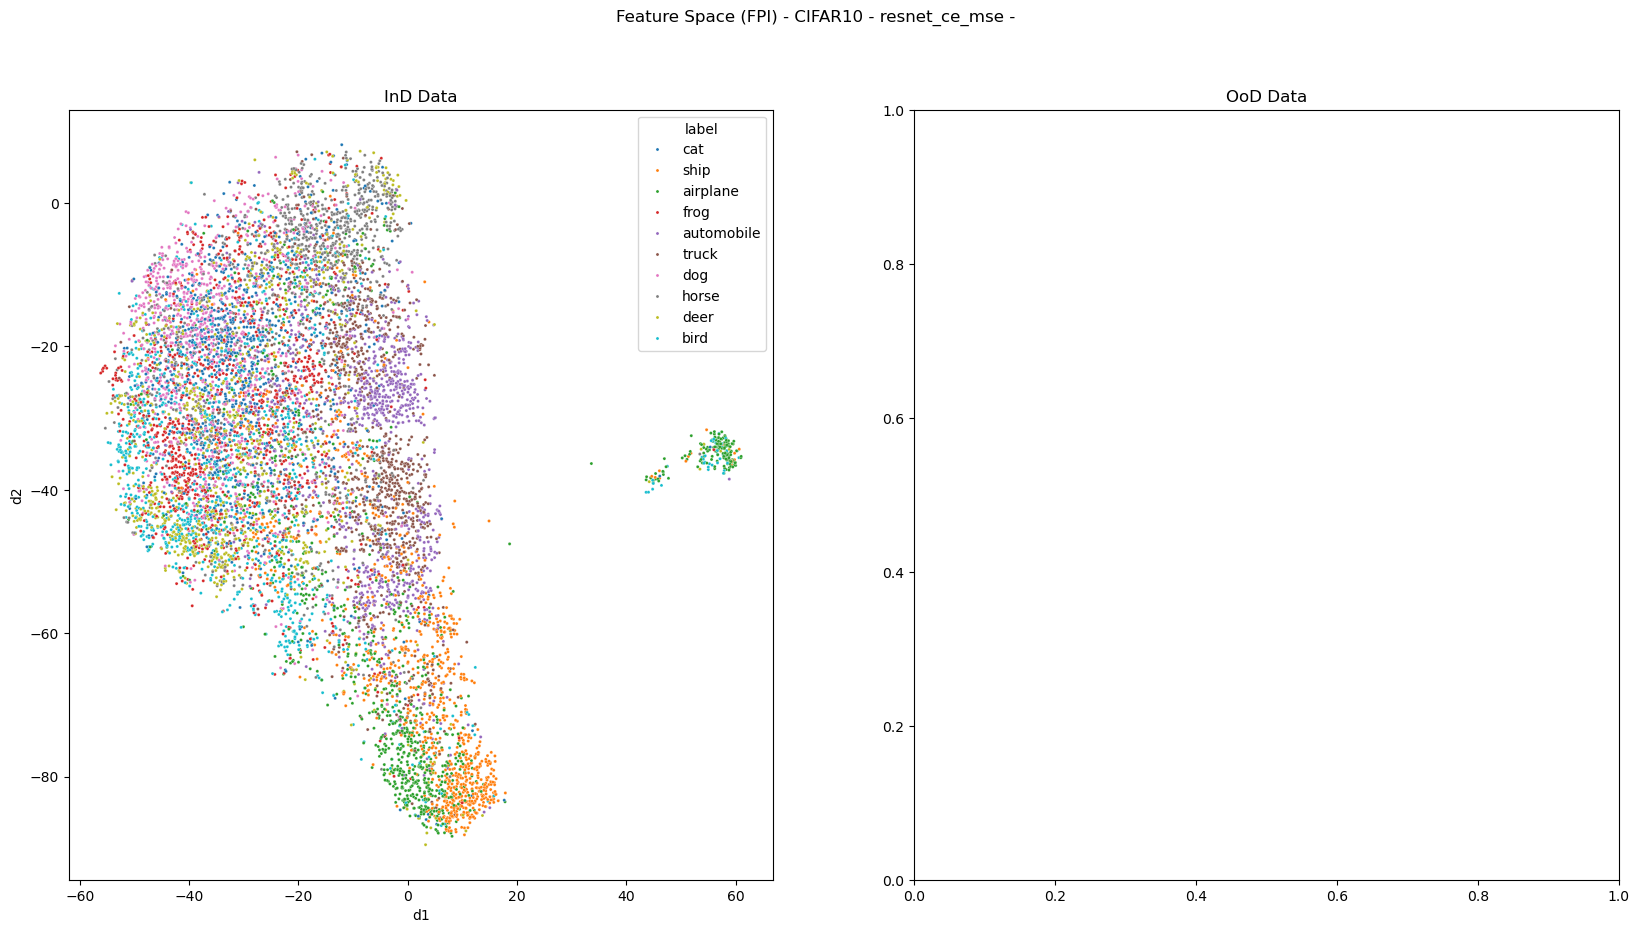

In [12]:
# plot feature space
df_emb_fpi2d = pd.DataFrame()
d1, d2 = ind_emb_fpi2d.T
df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_emb_fpi2d.T
    df_emb_fpi2d = pd.concat([df_emb_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Feature Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_emb_fpi2d[(df_emb_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

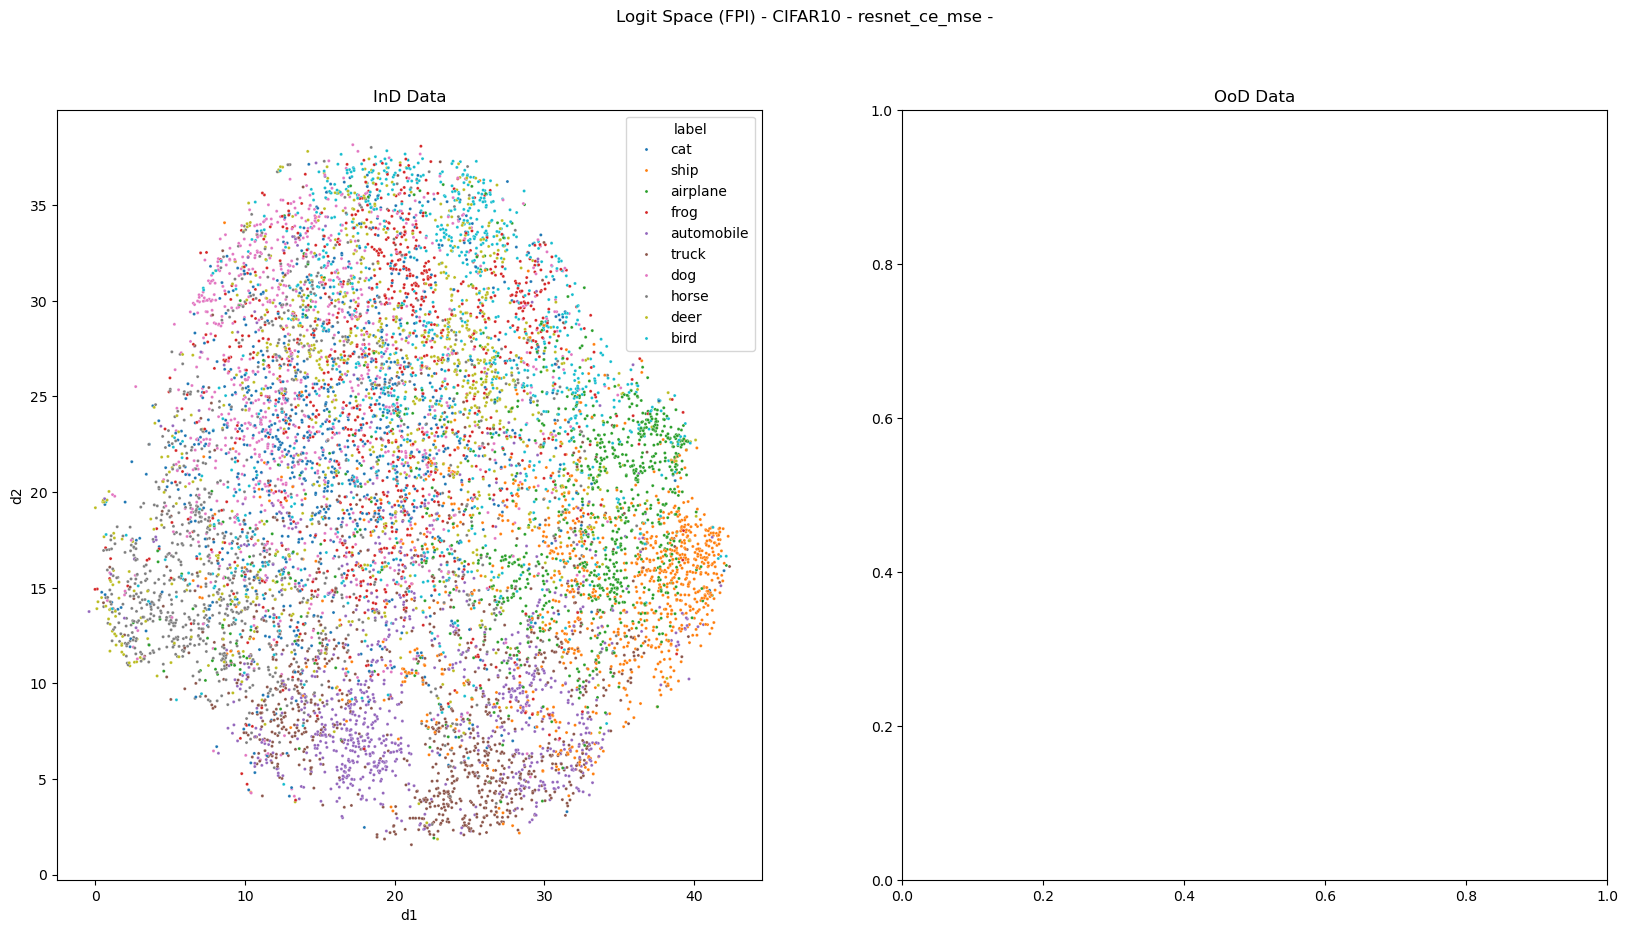

In [13]:
# plot logit space
df_lgt_fpi2d = pd.DataFrame()
d1, d2 = ind_lgt_fpi2d.T
df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ind_labels, source="ind"))])

if ood_str:
    d1, d2 = ood_lgt_fpi2d.T
    df_lgt_fpi2d = pd.concat([df_lgt_fpi2d, pd.DataFrame(dict(d1=d1, d2=d2, label=ood_labels, source="ood"))])

fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(20, 10))
fig.suptitle(f"Logit Space (FPI) - {dataset_name} - {model_name} - {ood_str}")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ind")], x="d1", y="d2", hue="label", s=5, ax=ax1)
ax1.set_title("InD Data")
sns.scatterplot(data=df_lgt_fpi2d[(df_lgt_fpi2d['source'] == "ood")], x="d1", y="d2", hue="label", s=5, ax=ax2)
ax2.set_title("OoD Data")
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:02,  1.07it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:01<00:01,  1.18it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:02<00:00,  1.21it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.18it/s]

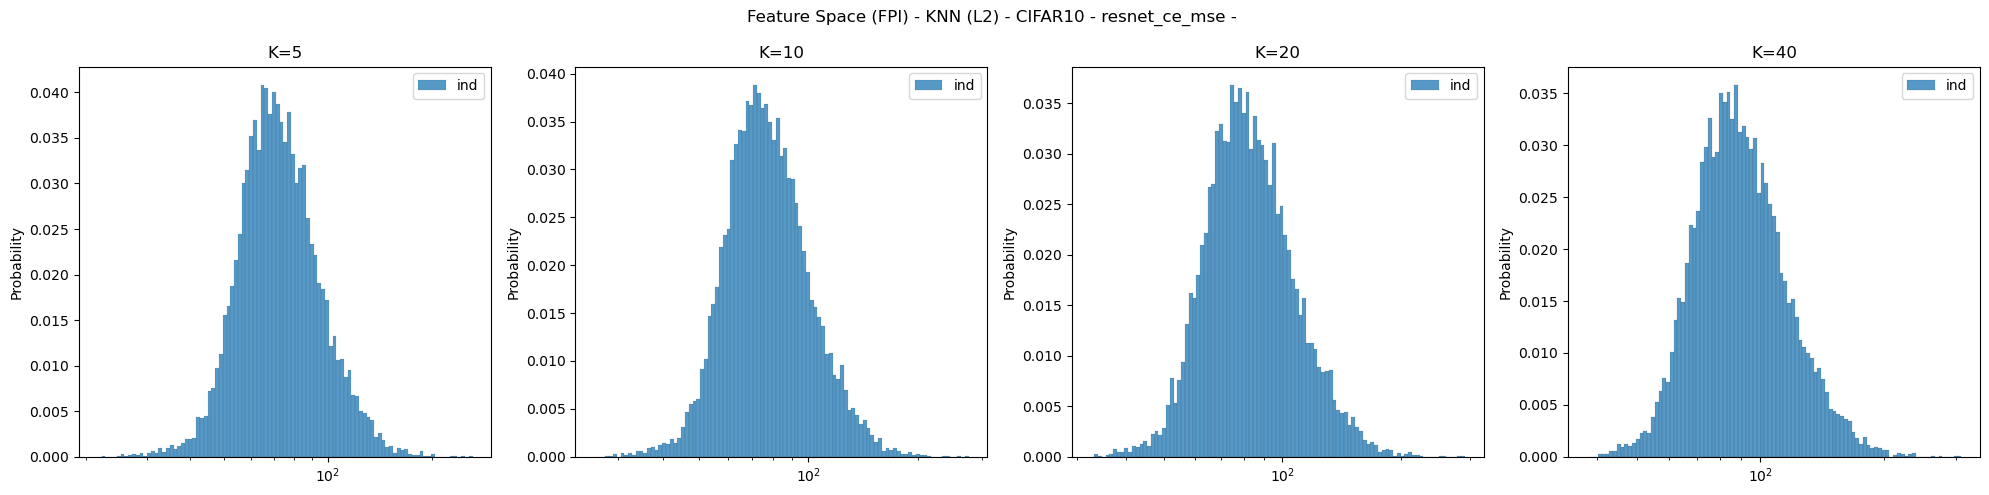

In [14]:
# plot knn to val data in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:02,  1.33it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:01<00:01,  1.32it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:02<00:00,  1.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]

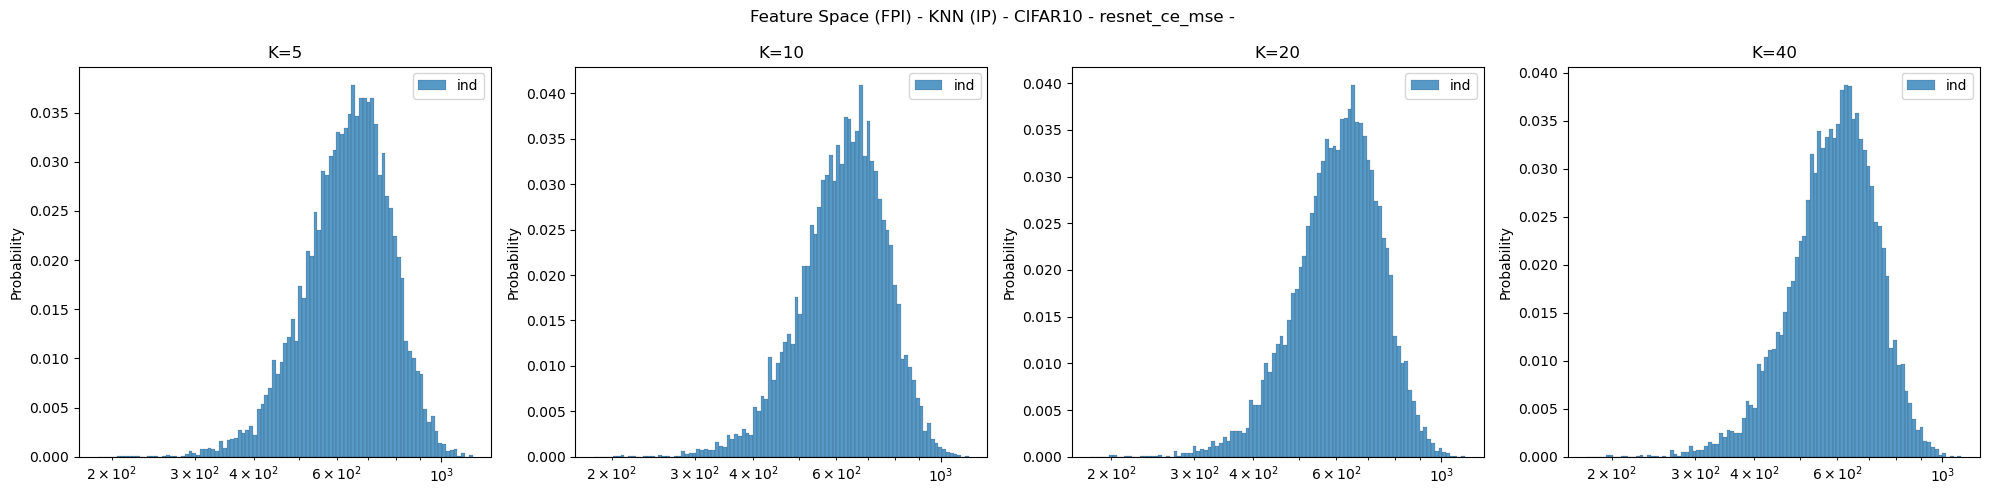

In [15]:
# check knn to val data in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:02,  1.30it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:01<00:01,  1.16it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:02<00:00,  1.20it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.19it/s]

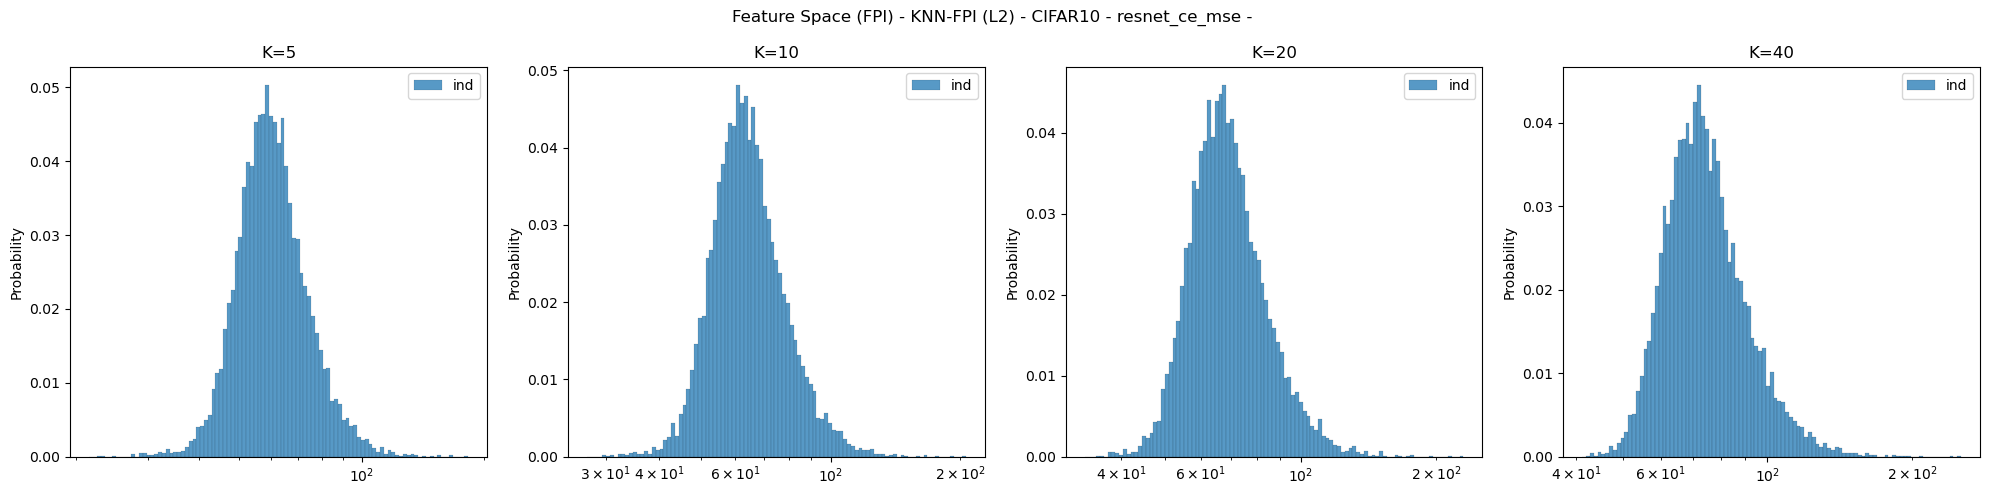

In [16]:
# check knn to val data FPI in feature space (L2)
index = faiss.IndexFlatL2(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:02,  1.33it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:01<00:01,  1.32it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:02<00:00,  1.30it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.26it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:03<00:00,  1.28it/s]

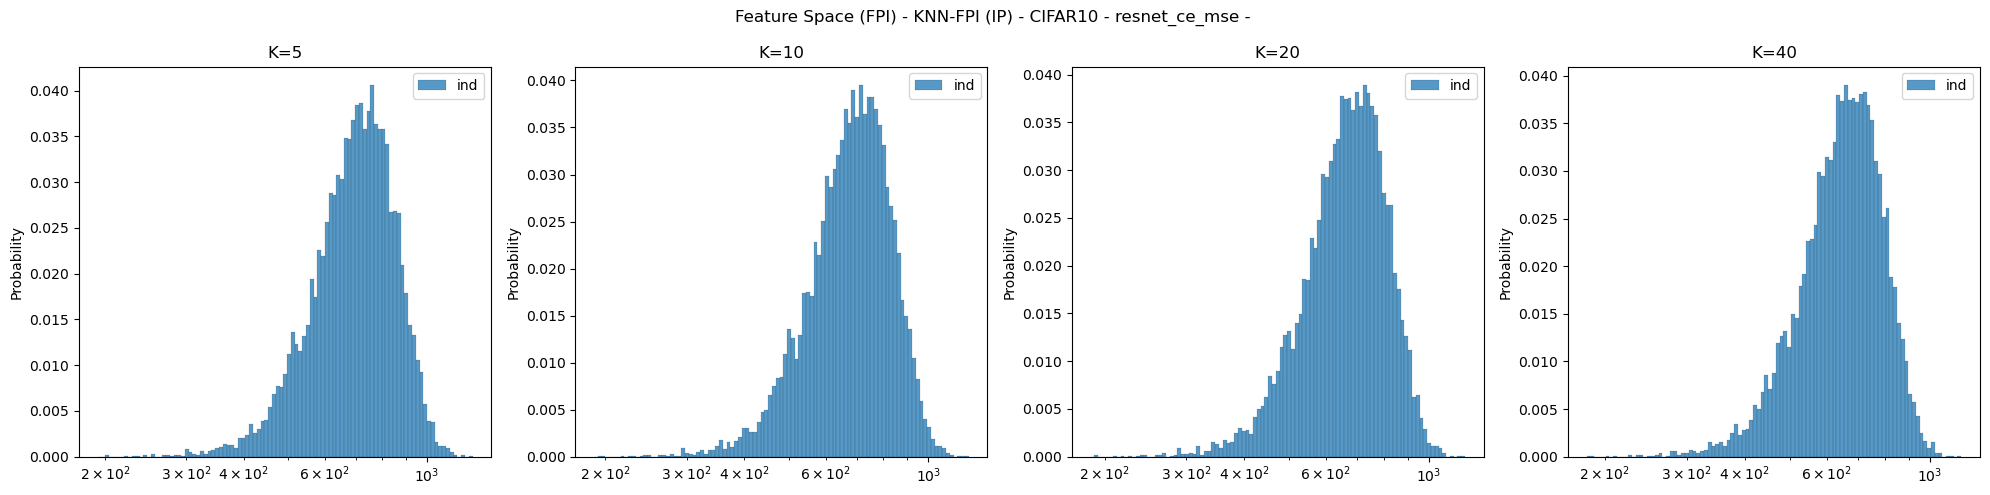

In [17]:
# check knn to val data FPI in feature space (IP)
index = faiss.IndexFlatIP(ind_emb_fpi.shape[-1])
index.add(val_emb_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Feature Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_emb_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_emb_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:00,  5.91it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  5.73it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:00<00:00,  5.28it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.93it/s]

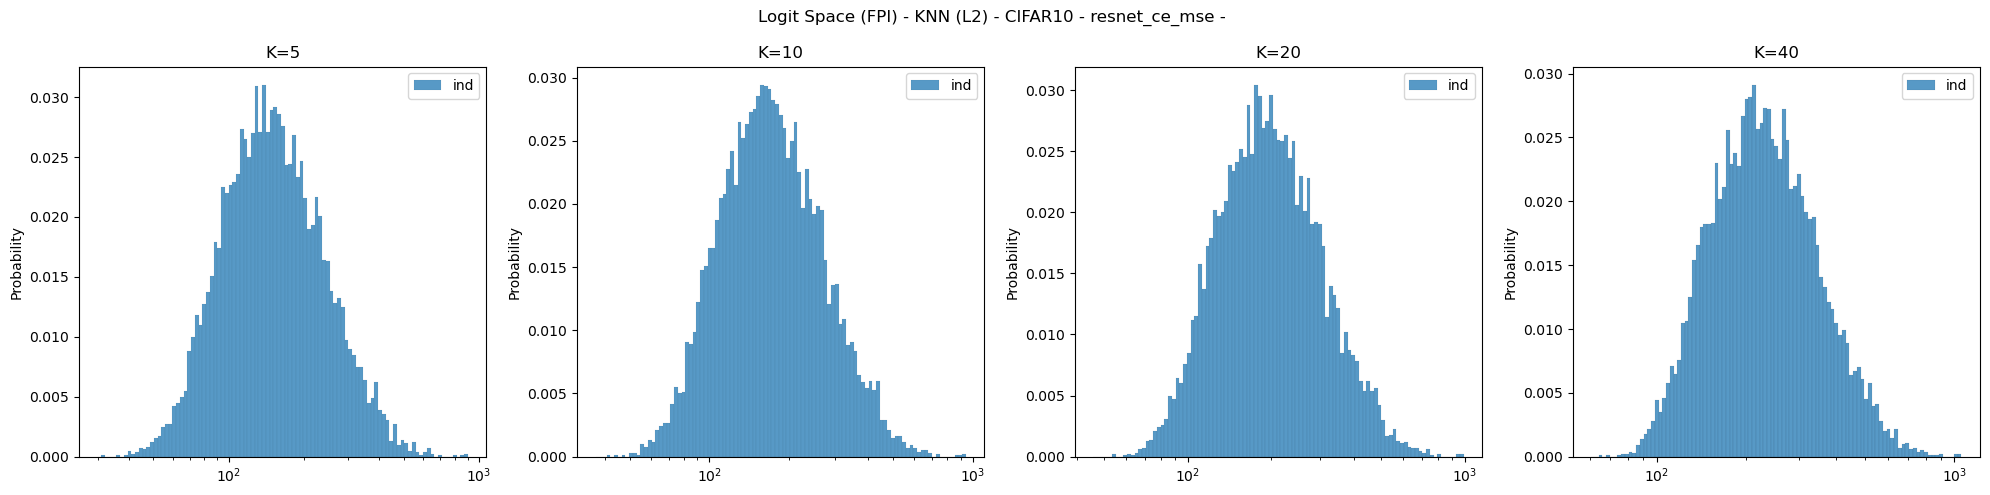

In [18]:
# check knn to val data in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:00,  6.23it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  6.09it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:00<00:00,  5.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.91it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  5.23it/s]

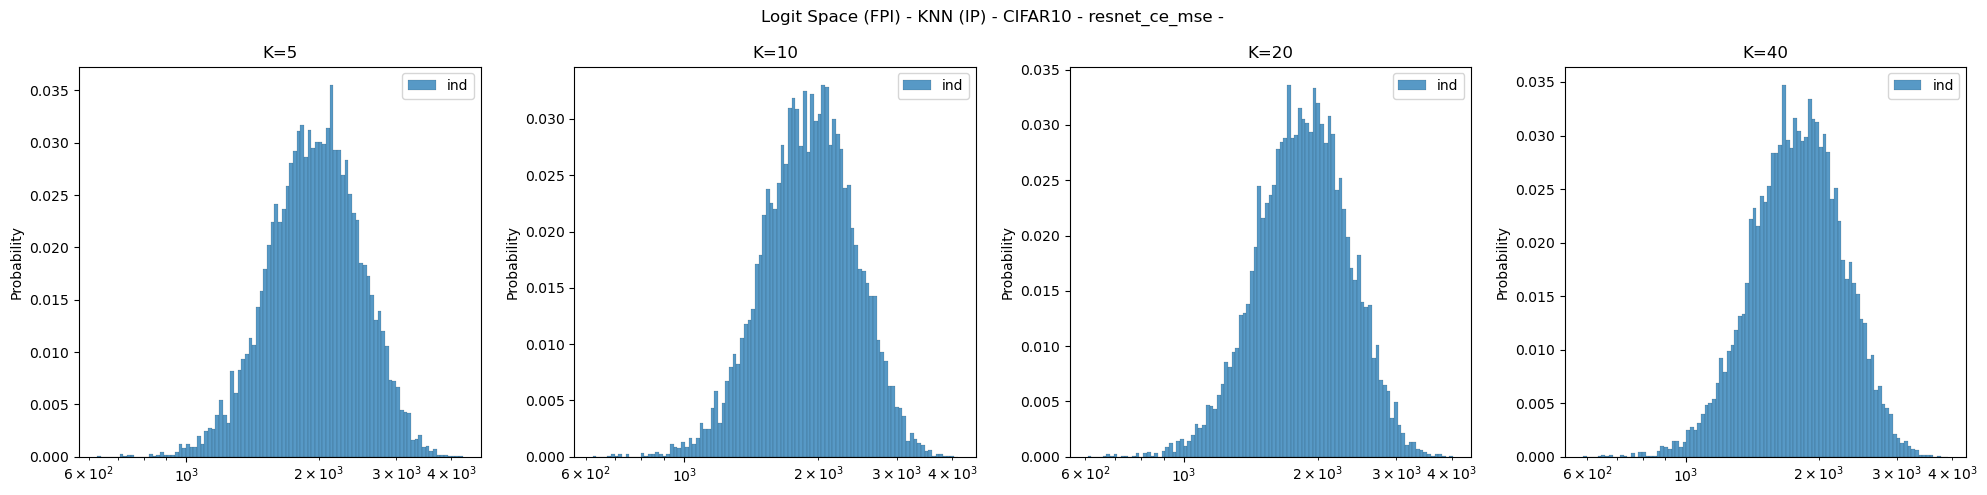

In [19]:
# check knn to val data in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:00,  5.83it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  5.66it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:00<00:00,  5.29it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.64it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.93it/s]

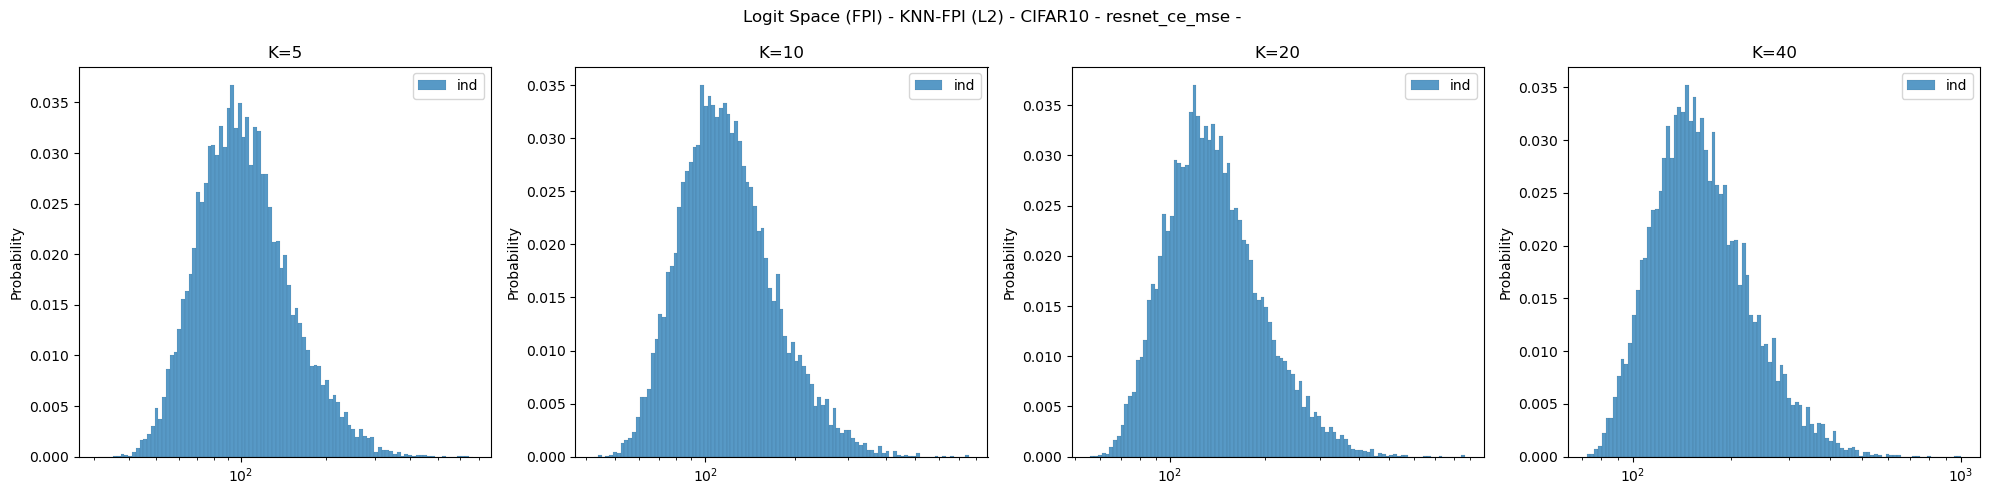

In [20]:
# check knn to val data FPI in logit space (L2)
index = faiss.IndexFlatL2(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (L2) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                 | 0/4 [00:00<?, ?it/s]

 25%|██████████████████████████████▎                                                                                          | 1/4 [00:00<00:00,  6.30it/s]

 50%|████████████████████████████████████████████████████████████▌                                                            | 2/4 [00:00<00:00,  6.11it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▊                              | 3/4 [00:00<00:00,  5.68it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  3.51it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.12it/s]

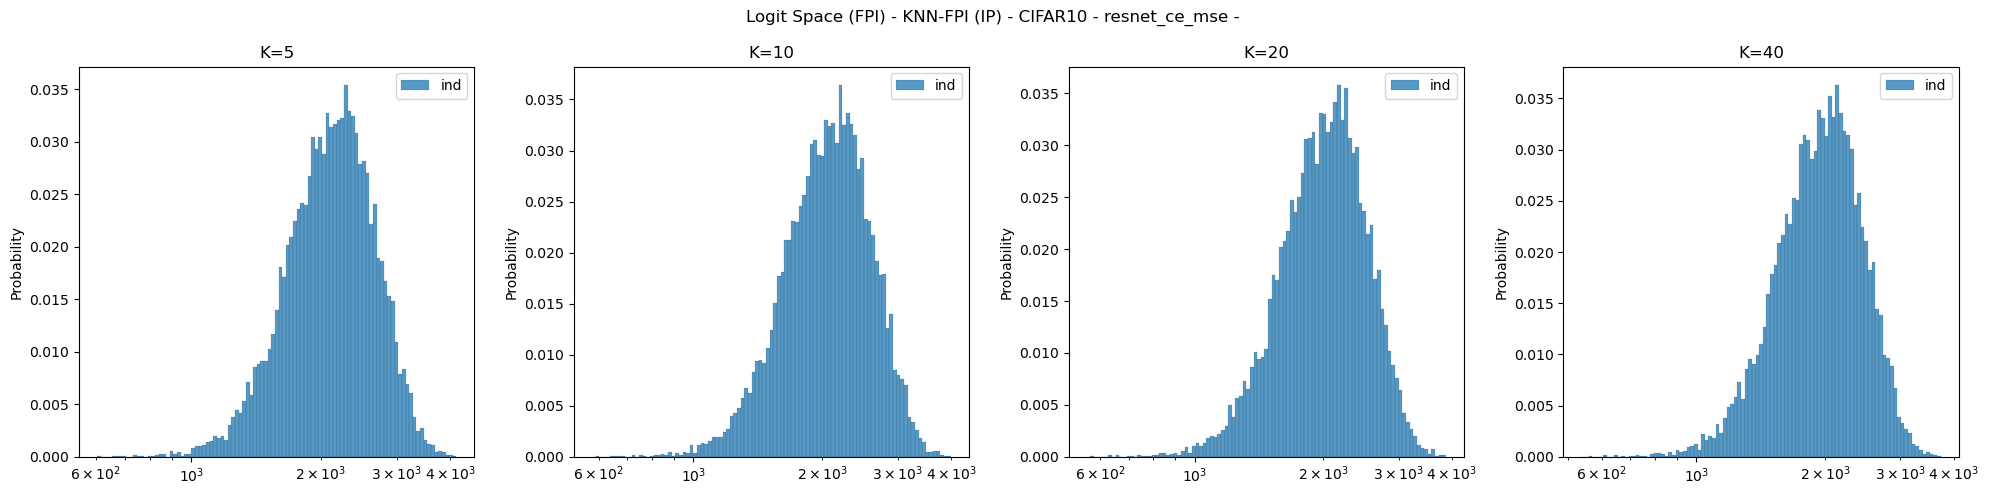

In [21]:
# check knn to val data FPI in logit space (IP)
index = faiss.IndexFlatIP(ind_lgt_fpi.shape[-1])
index.add(val_lgt_fpi)

fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))
fig.suptitle(f"Logit Space (FPI) - KNN-FPI (IP) - {dataset_name} - {model_name} - {ood_str}")

for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index.search(ind_lgt_fpi, k)[0].mean(-1)
    D = [Di]
    if ood_str:
        Do = index.search(ood_lgt_fpi, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min() + 1e-7), np.log10(D.max()), 100)
    ax = axs[j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

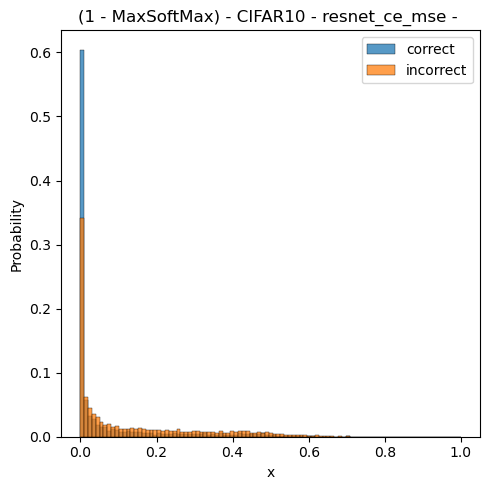

In [22]:
# plot (1 - maxsoftmax) distribution
ind_prob_fpi = np.exp(ind_lgt_fpi.astype(np.float64)) / np.exp(ind_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
ind_pred_fpi = ind_prob_fpi.argmax(-1)
ind_ucty_fpi = -ind_prob_fpi.max(-1) + 1.0

if ood_str:
    ood_prob_fpi = np.exp(ood_lgt_fpi.astype(np.float64)) / np.exp(ood_lgt_fpi.astype(np.float64)).sum(-1, keepdims=True)
    ood_pred_fpi = ood_prob_fpi.argmax(-1)
    ood_ucty_fpi = -ood_prob_fpi.max(-1) + 1.0

df_t_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi == ind_tgt]}).copy()
df_f_fpi = pd.DataFrame({"x": ind_ucty_fpi[ind_pred_fpi != ind_tgt]}).copy()
df_fpi = pd.concat([df_t_fpi, df_f_fpi], ignore_index=True)
if ood_str:
    df_o_fpi = pd.DataFrame({"x": ood_ucty_fpi}).copy()
    df_fpi = pd.concat([df_fpi, df_o_fpi], ignore_index=True)
df_fpi_bins = np.linspace(0, 1, 100)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5))
sns.histplot(df_t_fpi, x="x", label="correct", stat="probability", bins=df_fpi_bins, ax=ax)
sns.histplot(df_f_fpi, x="x", label="incorrect", stat="probability", bins=df_fpi_bins, ax=ax)
if ood_str:
    sns.histplot(df_o_fpi, x="x", label="ood", stat="probability", bins=df_fpi_bins, ax=ax)
plt.legend()
plt.title(f"(1 - MaxSoftMax) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()

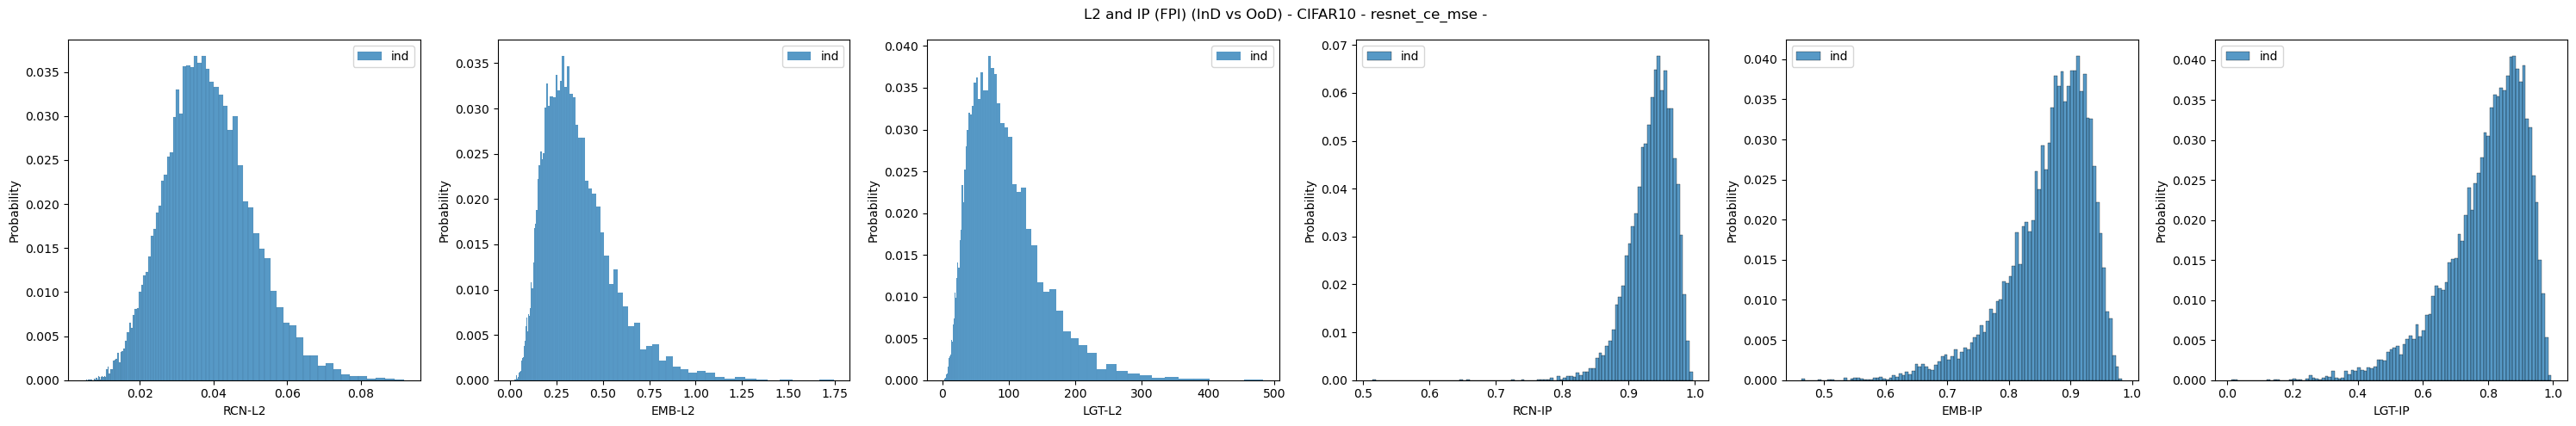

In [23]:
# plot fpi-reconstruction-based ood metrics
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=1, ncols=6, figsize=(30, 5))

df_rstat = pd.DataFrame()
ni = ind_inp.shape[0]
si = (ni, -1)
# data
_ind_inp = ind_inp.reshape(si)
_ind_rcn = ind_rcn.reshape(si)
_ind_emb = ind_emb.reshape(si)
_ind_lgt = ind_lgt.reshape(si)
_ind_rcn_fpi = ind_rcn_fpi.reshape(si)
_ind_emb_fpi = ind_emb_fpi.reshape(si)
_ind_lgt_fpi = ind_lgt_fpi.reshape(si)
# unit vectors
_ind_inp_unit = _ind_inp / (np.linalg.norm(_ind_inp, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_unit = _ind_rcn / (np.linalg.norm(_ind_rcn, axis=-1, keepdims=True) + 1e-7)
_ind_emb_unit = _ind_emb / (np.linalg.norm(_ind_emb, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_unit = _ind_lgt / (np.linalg.norm(_ind_lgt, axis=-1, keepdims=True) + 1e-7)
_ind_rcn_fpi_unit = _ind_rcn_fpi / (np.linalg.norm(_ind_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_emb_fpi_unit = _ind_emb_fpi / (np.linalg.norm(_ind_emb_fpi, axis=-1, keepdims=True) + 1e-7)
_ind_lgt_fpi_unit = _ind_lgt_fpi / (np.linalg.norm(_ind_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
# mse
ind_rcn_l2_fpi = ((_ind_inp - _ind_rcn_fpi) ** 2).mean(-1)
ind_emb_l2_fpi = ((_ind_emb - _ind_emb_fpi) ** 2).mean(-1)
ind_lgt_l2_fpi = ((_ind_lgt - _ind_lgt_fpi) ** 2).mean(-1)
# ip
ind_rcn_ip_fpi = (_ind_inp_unit * _ind_rcn_fpi_unit).sum(-1)
ind_emb_ip_fpi = (_ind_emb_unit * _ind_emb_fpi_unit).sum(-1)
ind_lgt_ip_fpi = (_ind_lgt_unit * _ind_lgt_fpi_unit).sum(-1)
# store
_df = pd.DataFrame(dict(
    target=ind_tgt,
    rcn_l2=ind_rcn_l2_fpi,
    emb_l2=ind_emb_l2_fpi,
    lgt_l2=ind_lgt_l2_fpi,
    rcn_ip=ind_rcn_ip_fpi,
    emb_ip=ind_emb_ip_fpi,
    lgt_ip=ind_lgt_ip_fpi,
    source="ind",
))
df_rstat = pd.concat([df_rstat, _df], ignore_index=True)

if ood_str:
    no = ood_inp.shape[0]
    so = (no, -1)
    # data
    _ood_inp = ood_inp.reshape(so)
    _ood_rcn = ood_rcn.reshape(so)
    _ood_emb = ood_emb.reshape(so)
    _ood_lgt = ood_lgt.reshape(so)
    _ood_rcn_fpi = ood_rcn_fpi.reshape(so)
    _ood_emb_fpi = ood_emb_fpi.reshape(so)
    _ood_lgt_fpi = ood_lgt_fpi.reshape(so)
    # unit vectors
    _ood_inp_unit = _ood_inp / (np.linalg.norm(_ood_inp, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_unit = _ood_rcn / (np.linalg.norm(_ood_rcn, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_unit = _ood_emb / (np.linalg.norm(_ood_emb, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_unit = _ood_lgt / (np.linalg.norm(_ood_lgt, axis=-1, keepdims=True) + 1e-7)
    _ood_rcn_fpi_unit = _ood_rcn_fpi / (np.linalg.norm(_ood_rcn_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_emb_fpi_unit = _ood_emb_fpi / (np.linalg.norm(_ood_emb_fpi, axis=-1, keepdims=True) + 1e-7)
    _ood_lgt_fpi_unit = _ood_lgt_fpi / (np.linalg.norm(_ood_lgt_fpi, axis=-1, keepdims=True) + 1e-7)
    # mse
    ood_rcn_l2_fpi = ((_ood_inp - _ood_rcn_fpi) ** 2).mean(-1)
    ood_emb_l2_fpi = ((_ood_emb - _ood_emb_fpi) ** 2).mean(-1)
    ood_lgt_l2_fpi = ((_ood_lgt - _ood_lgt_fpi) ** 2).mean(-1)
    # ip
    ood_rcn_ip_fpi = (_ood_inp_unit * _ood_rcn_fpi_unit).sum(-1)
    ood_emb_ip_fpi = (_ood_emb_unit * _ood_emb_fpi_unit).sum(-1)
    ood_lgt_ip_fpi = (_ood_lgt_unit * _ood_lgt_fpi_unit).sum(-1)
    # store
    _df = pd.DataFrame(dict(
        target=ood_tgt,
        rcn_l2=ood_rcn_l2_fpi,
        emb_l2=ood_emb_l2_fpi,
        lgt_l2=ood_lgt_l2_fpi,
        rcn_ip=ood_rcn_ip_fpi,
        emb_ip=ood_emb_ip_fpi,
        lgt_ip=ood_lgt_ip_fpi,
        source="ood",
    ))
    df_rstat = pd.concat([df_rstat, _df], ignore_index=True)
    
bins_rcn_l2 = np.logspace(np.log10(df_rstat['rcn_l2'].min() + 1e-7), np.log10(df_rstat['rcn_l2'].max()), 100)
bins_emb_l2 = np.logspace(np.log10(df_rstat['emb_l2'].min() + 1e-7), np.log10(df_rstat['emb_l2'].max()), 100)
bins_lgt_l2 = np.logspace(np.log10(df_rstat['lgt_l2'].min() + 1e-7), np.log10(df_rstat['lgt_l2'].max()), 100)
bins_rcn_ip = np.linspace(df_rstat['rcn_ip'].min(), df_rstat['rcn_ip'].max(), 100)
bins_emb_ip = np.linspace(df_rstat['emb_ip'].min(), df_rstat['emb_ip'].max(), 100)
bins_lgt_ip = np.linspace(df_rstat['lgt_ip'].min(), df_rstat['lgt_ip'].max(), 100)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
sns.histplot(df_rstat[df_rstat['source'] == 'ind'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

if ood_str:
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_l2", label="ind", stat="probability", bins=bins_rcn_l2, ax=ax1)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_l2", label="ind", stat="probability", bins=bins_emb_l2, ax=ax2)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_l2", label="ind", stat="probability", bins=bins_lgt_l2, ax=ax3)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="rcn_ip", label="ind", stat="probability", bins=bins_rcn_ip, ax=ax4)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="emb_ip", label="ind", stat="probability", bins=bins_emb_ip, ax=ax5)
    sns.histplot(df_rstat[df_rstat['source'] == 'ood'], x="lgt_ip", label="ind", stat="probability", bins=bins_lgt_ip, ax=ax6)

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
ax5.legend()
ax6.legend()
ax1.set_xlabel("RCN-L2")
ax2.set_xlabel("EMB-L2")
ax3.set_xlabel("LGT-L2")
ax4.set_xlabel("RCN-IP")
ax5.set_xlabel("EMB-IP")
ax6.set_xlabel("LGT-IP")
plt.suptitle(f"L2 and IP (FPI) (InD vs OoD) - {dataset_name} - {model_name} - {ood_str}")
plt.tight_layout()
plt.show()